In [ ]:
# A FAULT DETECTION & CLASSIFICATION MODEL for Manufactory 

###### Data Set Information:

###### The data set was experimentally obtained with a hydraulic test rig. This test rig consists of a primary working and a secondary cooling-filtration circuit which are connected via the oil tank [1], [2]. The system cyclically repeats constant load cycles (duration 60 seconds) and measures process values such as pressures, volume flows and temperatures while the condition of four hydraulic components (cooler, valve, pump and accumulator) is quantitatively varied.


###### Attribute Information:

###### The data set was experimentally obtained with a hydraulic test rig. This test rig consists of a primary working and a secondary cooling-filtration circuit which are connected via the oil tank [1], [2]. The system cyclically repeats constant load cycles (duration 60 seconds) and measures process values such as pressures, volume flows and temperatures while the condition of four hydraulic components (cooler, valve, pump and accumulator) is quantitatively varied.

###### Attribute Information:
###### The data set contains raw process sensor data (i.e. without feature extraction) which are structured as matrices (tab-delimited) with the rows representing the cycles and the columns the data points within a cycle. The sensors involved are:
###### Sensor Physical quantity Unit Sampling rate
###### PS1 Pressure bar 100 Hz
###### PS2 Pressure bar 100 Hz
###### PS3 Pressure bar 100 Hz
###### PS4 Pressure bar 100 Hz
###### PS5 Pressure bar 100 Hz
###### PS6 Pressure bar 100 Hz
###### EPS1 Motor power W 100 Hz
###### FS1 Volume flow l/min 10 Hz
###### FS2 Volume flow l/min 10 Hz
###### TS1 Temperature Â°C 1 Hz
###### TS2 Temperature Â°C 1 Hz
###### TS3 Temperature Â°C 1 Hz
###### TS4 Temperature Â°C 1 Hz
###### VS1 Vibration mm/s 1 Hz
###### CE Cooling efficiency (virtual) % 1 Hz
###### CP Cooling power (virtual) kW 1 Hz
###### SE Efficiency factor % 1 Hz

###### The target condition values are cycle-wise annotated in â€˜profile.txtâ€˜ (tab-delimited). As before, the row number represents the cycle number. The columns are

###### 1: Cooler condition / %:
###### 3: close to total failure
###### 20: reduced effifiency
###### 100: full efficiency

###### 2: Valve condition / %:
###### 100: optimal switching behavior
###### 90: small lag
###### 80: severe lag
###### 73: close to total failure

###### 3: Internal pump leakage:
###### 0: no leakage
###### 1: weak leakage
###### 2: severe leakage

###### 4: Hydraulic accumulator / bar:
###### 130: optimal pressure
###### 115: slightly reduced pressure
###### 100: severely reduced pressure
###### 90: close to total failure

###### 5: stable flag:
###### 0: conditions were stable
###### 1: static conditions might not have been reached yet



In [67]:
import pandas as pd      
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler,OrdinalEncoder
import plotly.express as px
from ipywidgets import interact
from ipywidgets import widgets
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix,classification_report




import warnings
warnings.filterwarnings('ignore')
######plt.rcParams["figure.figsize"] = (7,4)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 700)

In [4]:
df = pd.read_csv(r"avery.txt",usecols=['Time', 'Cooling efficiency', 'Cooling power',
       'Motor power W', 'Volume flow l/min 1', 'Volume flow l/min 2',
       'Pressure bar 1', 'Pressure bar 2', 'Pressure bar 3', 'Pressure bar 4',
       'Pressure bar 5', 'Pressure bar 6', 'Efficiency factor',
       'Temperature 1', 'Temperature  2', 'Temperature  3', 'Temperature  4',
       ' Vibration mm/s', 'Date'])

In [5]:
df.head()

,Time,Cooling efficiency,Cooling power,Motor power W,Volume flow l/min 1,Volume flow l/min 2,Pressure bar 1,Pressure bar 2,Pressure bar 3,Pressure bar 4,Pressure bar 5,Pressure bar 6,Efficiency factor,Temperature 1,Temperature 2,Temperature 3,Temperature 4,Vibration mm/s,Date
0,0,47.202,2.184,2411.6,8.990,10.179,151.47,125.50,2.305,0.0,9.936,9.818,68.039,35.570,40.961,38.320,30.363,0.604,2018-04-26 00:00:00
1,60,29.208,1.414,2409.6,8.919,10.408,151.11,125.06,2.281,0.0,9.700,9.592,68.264,36.156,41.258,38.680,33.648,0.590,2018-04-26 01:00:00
2,120,23.554,1.159,2397.8,9.179,10.392,150.81,125.13,2.227,0.0,9.606,9.505,68.595,37.488,42.129,39.234,35.113,0.578,2018-04-26 02:00:00
3,180,21.540,1.101,2383.8,9.034,10.329,150.48,124.93,2.320,0.0,9.528,9.422,68.628,38.633,43.039,40.086,36.133,0.565,2018-04-26 03:00:00
4,240,20.460,1.086,2372.0,8.729,10.276,150.41,124.72,2.250,0.0,9.408,9.315,68.868,39.461,44.031,40.934,36.992,0.570,2018-04-26 04:00:00


In [6]:
label_df = pd.read_csv("profile.txt",delimiter="\t"   , names=["Cooler condition","Valve condition","Internal pump leakage","Hydraulic accumulator","stable flag"])

In [7]:
label_df.head()

,Cooler condition,Valve condition,Internal pump leakage,Hydraulic accumulator,stable flag
0,3,100,0,130,1
1,3,100,0,130,1
2,3,100,0,130,1
3,3,100,0,130,1
4,3,100,0,130,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Time                 2205 non-null   int64  
 1   Cooling efficiency   2205 non-null   float64
 2   Cooling power        2205 non-null   float64
 3   Motor power W        2205 non-null   float64
 4   Volume flow l/min 1  2205 non-null   float64
 5   Volume flow l/min 2  2205 non-null   float64
 6   Pressure bar 1       2205 non-null   float64
 7   Pressure bar 2       2205 non-null   float64
 8   Pressure bar 3       2205 non-null   float64
 9   Pressure bar 4       2205 non-null   float64
 10  Pressure bar 5       2205 non-null   float64
 11  Pressure bar 6       2205 non-null   float64
 12  Efficiency factor    2205 non-null   float64
 13  Temperature 1        2205 non-null   float64
 14  Temperature  2       2205 non-null   float64
 15  Temperature  3       2205 non-null   f

In [9]:
df.isnull().sum()

Time                   0
Cooling efficiency     0
Cooling power          0
Motor power W          0
Volume flow l/min 1    0
Volume flow l/min 2    0
Pressure bar 1         0
Pressure bar 2         0
Pressure bar 3         0
Pressure bar 4         0
Pressure bar 5         0
Pressure bar 6         0
Efficiency factor      0
Temperature 1          0
Temperature  2         0
Temperature  3         0
Temperature  4         0
 Vibration mm/s        0
Date                   0
dtype: int64

In [10]:
df.duplicated().sum()

0

In [11]:
label_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   Cooler condition       2205 non-null   int64
 1   Valve condition        2205 non-null   int64
 2   Internal pump leakage  2205 non-null   int64
 3   Hydraulic accumulator  2205 non-null   int64
 4   stable flag            2205 non-null   int64
dtypes: int64(5)
memory usage: 86.3 KB


In [12]:
df.Date = pd.to_datetime(df.Date)

In [13]:
label_df.columns = label_df.columns.str.replace(" ","_").str.lower()

## LABELS

## Cooler condition

##### 3: close to total failure
##### 20: reduced effifiency
##### 100: full efficiency

In [14]:
label_df.cooler_condition = label_df.cooler_condition.apply(lambda x : "close to total failure" if x == 3 else ("reduced effifiency" if x == 20 else ("full efficiency" if x == 100 else x)))

In [15]:
label_df.cooler_condition.sample(5)

1745           full efficiency
1556           full efficiency
2103           full efficiency
1285        reduced effifiency
665     close to total failure
Name: cooler_condition, dtype: object

## Valve condition

#### 100: optimal switching behavio
#### 90: small lag
#### 80: severe lag

In [16]:
label_df.valve_condition = label_df.valve_condition.apply(lambda x : "optimal switching behavior" if x == 100 else ("small lag" if x == 90 else "severe lag" if x == 80 else ("close to total failure" if x == 73 else x)))

In [17]:
label_df.valve_condition.sample(5)

595     optimal switching behavior
1648    optimal switching behavior
1411                     small lag
1463    optimal switching behavior
1754    optimal switching behavior
Name: valve_condition, dtype: object

## Internal pump leakage

#### 0: no leakage
#### 1: weak leakage
#### 2: severe leakage

In [18]:
label_df.internal_pump_leakage = label_df.internal_pump_leakage.apply(lambda x : "no leakage" if x == 0 else ("weak leakage" if x == 1 else ("severe leakage" if x == 2 else x)))

In [19]:
label_df.internal_pump_leakage.sample(5)

1905      no leakage
1650      no leakage
387     weak leakage
1800      no leakage
569       no leakage
Name: internal_pump_leakage, dtype: object

## Hydraulic accumulator

#### 130: optimal pressure
#### 115: slightly reduced pressure
#### 100: severely reduced pressure
#### 90: close to total failure

In [20]:
label_df.hydraulic_accumulator = label_df.hydraulic_accumulator.apply(lambda x : "optimal pressure" if x == 130 else ("slightly reduced pressure" if x == 115 else ("severely reduced pressure" if x == 100 else ("close to total faiure" if x == 90  else x ))))

In [21]:
label_df.hydraulic_accumulator.sample(5)

949              optimal pressure
404     slightly reduced pressure
1685             optimal pressure
1620        close to total faiure
2089        close to total faiure
Name: hydraulic_accumulator, dtype: object

## Stable flag

#### 0: conditions were stable
#### 1: static conditions might not have been reached yet

In [22]:
label_df.stable_flag = label_df.stable_flag.apply(lambda x : "conditions were stable" if x == 0 else "static conditions might not have been reached yet")

In [23]:
label_df.stable_flag.sample(5)

2079                               conditions were stable
937     static conditions might not have been reached yet
517     static conditions might not have been reached yet
481                                conditions were stable
2169                               conditions were stable
Name: stable_flag, dtype: object

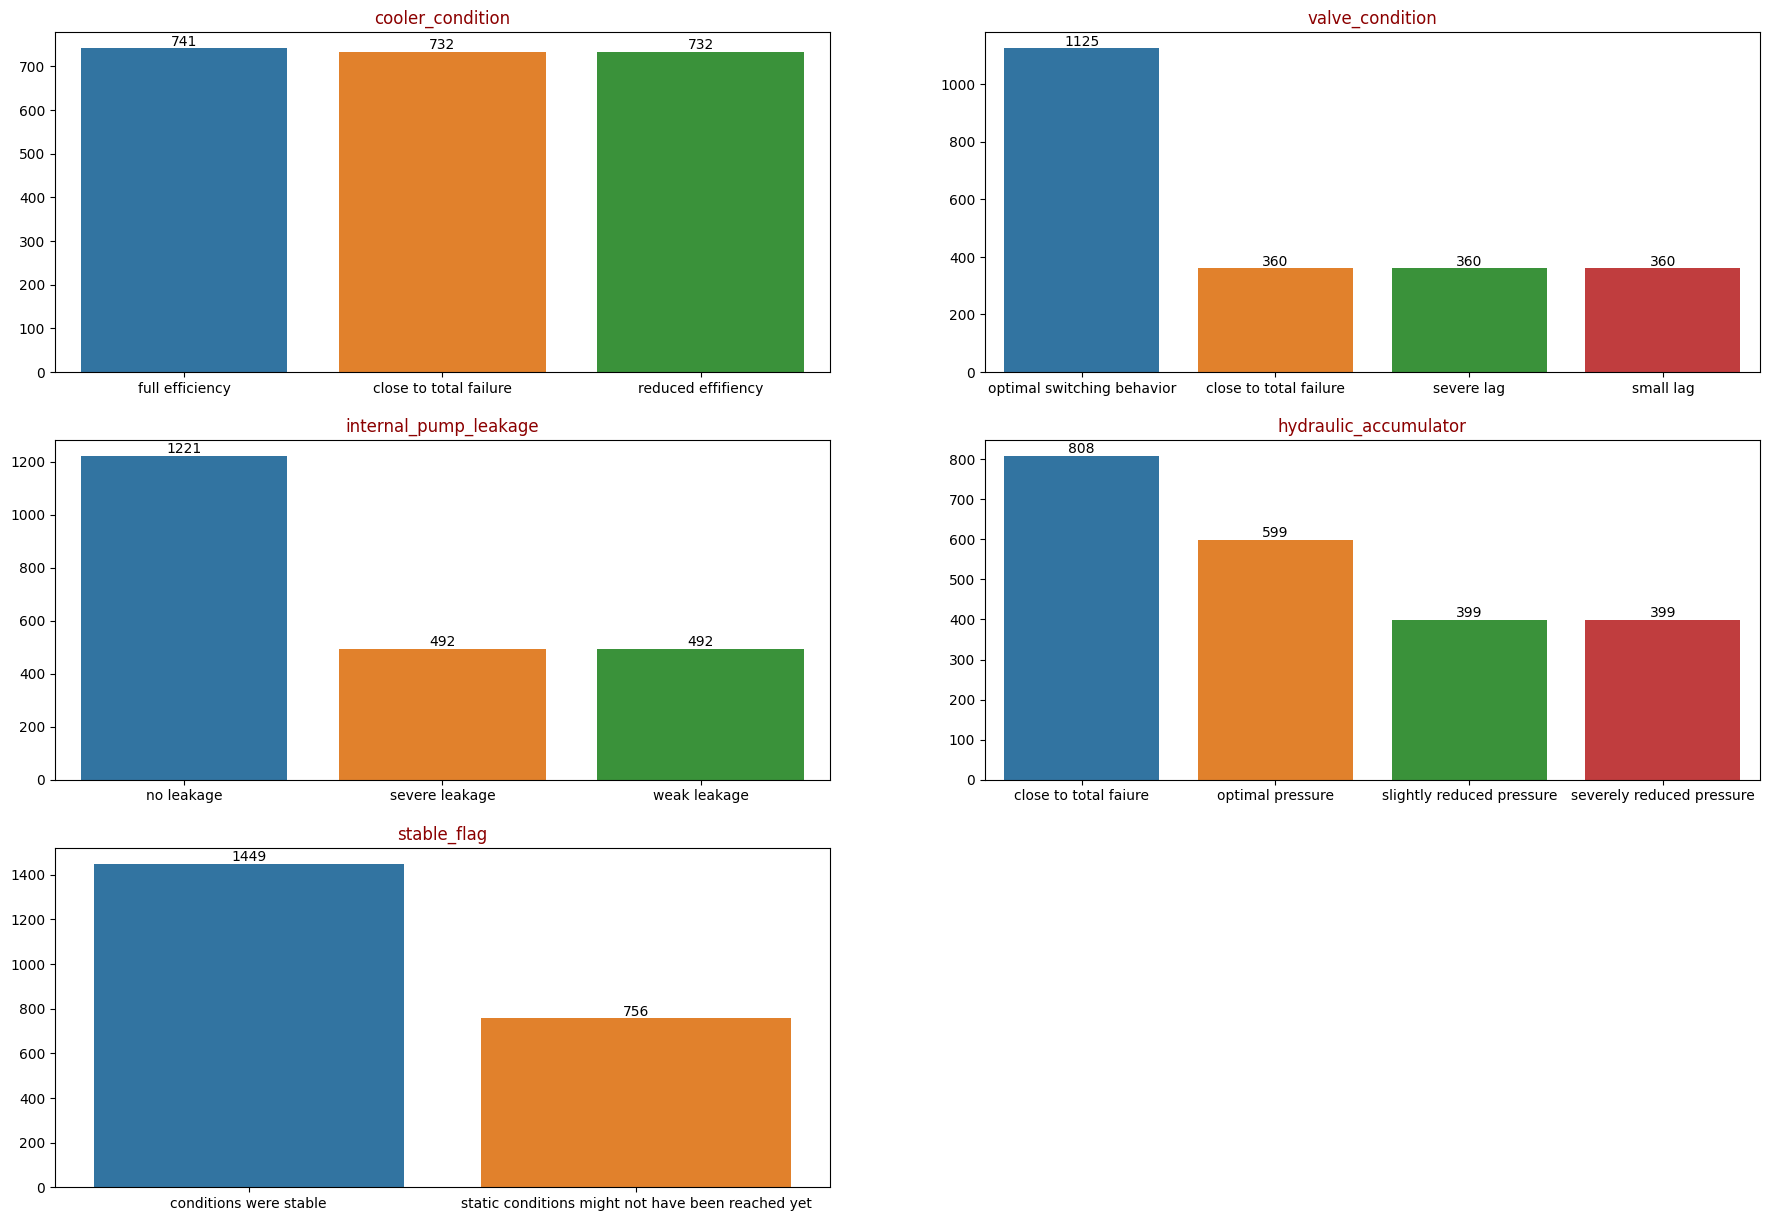

In [24]:
k=1
plt.figure(figsize = (22,15))
for i in label_df.columns:
    plt.subplot(3,2,k)
    ax = sns.barplot(x = label_df[i].value_counts().index,y=label_df[i].value_counts().values)
    plt.xticks(rotation = 0)
    plt.xlabel(None)
    plt.title("{}".format(i),color="darkred")
    for i in ax.containers:
        ax.bar_label(i)
    k+=1

In [25]:
combined_df = pd.concat(objs=[df,label_df],axis = 1)

In [26]:
from plotly.express import scatter_3d
from ipywidgets import interact

In [27]:
def scatter_3dim(f1,f2,f3,cat_col):
    scatter_3d(data_frame=combined_df,x=f1,y=f2,z=f3,color=cat_col,width=750,height=500).show()

In [28]:
def interactive():
    interact(scatter_3dim,f1=df.columns,f2=df.columns,f3=df.columns,cat_col = label_df.columns)

In [29]:
interactive()

interactive(children=(Dropdown(description='f1', options=('Time', 'Cooling efficiency', 'Cooling power', 'Moto…

In [64]:
def classifier(feature,CLF):
    """ Predict the classes with classifier model "CLF" for class column "feature" """
    
    # Encoding labels
    enc = OrdinalEncoder()
    
    #Transforming labels
    encoded_label =  enc.fit_transform(label_df[feature].to_frame())
    
    # Visualizing the encoded labels
    #y_all_df= pd.DataFrame(data = encoded_label_df,columns=label_df.columns)
    
    # Selecting classifier
    clf = CLF
    
    # train data
    X=df.drop("Date",axis = 1) 
    
    # test data
    y = encoded_label   
    
    #splitting train test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y , test_size=0.2, random_state=42) 
    
    # Fitting model
    clf.fit(X_train,y_train)
    
    # Making predictions
    y_pred = clf.predict(X_test)
    compare_y = pd.DataFrame(enc.inverse_transform(y_pred.reshape(-1,1)),columns=["predictions"])
    actual = enc.inverse_transform(y_test)
    compare_y["actual"] = actual.reshape(-1,)
    
    #Evaulating results with classification report metrics (precision, recall, accuracy,f1)
    print("\n      CLASSIFICATION REPORT for {}\n\n".format(CLF),classification_report(y_test,y_pred))
    
    # Feature importances
    plt.figure(figsize = (26,5))
    plt.subplot(1,1,1)
    feature_importances = pd.DataFrame(data = clf.feature_importances_,index=clf.feature_names_in_,columns=["coef"]).sort_values(by="coef",ascending=False)
    ax=sns.barplot(x = feature_importances.index,y=feature_importances.coef)
    for i in ax.containers:ax.bar_label(i,fmt = "%.2f")
    plt.title("Feature Impportances")
    
    # Visualizing Confusing Matrix
    ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred)).plot()
   
    return compare_y.T
    

## Implementing RandomForest, XGB , AdaBoosT, DecisionTree, GradientBoosting classifiers for "MULTICLASS" classification with vanilla form of algorithms

In [65]:
algoritmhs= [RandomForestClassifier(),XGBClassifier(),AdaBoostClassifier(),DecisionTreeClassifier(),GradientBoostingClassifier()]

In [66]:
interact(classifier,feature = label_df.columns[:-1],CLF = [RandomForestClassifier(),XGBClassifier(),AdaBoostClassifier(),DecisionTreeClassifier(),GradientBoostingClassifier()])

interactive(children=(Dropdown(description='feature', options=('cooler_condition', 'valve_condition', 'interna…

<function __main__.classifier(feature, CLF)>

## Implementing RandomForest, XGB , AdaBoosT, DecisionTree, GradientBoosting classifiers for "BINARY" classification with vanilla forms of algorithms

In [39]:
interact(classifier,feature = "stable_flag",CLF = algoritmhs)

interactive(children=(Text(value='stable_flag', description='feature'), Dropdown(description='CLF', options=(R…

<function __main__.classifier(feature, CLF)>